# 프로젝트16 - Segmentation map으로 도로 이미지 만들기
이번 프로젝트는 cityscapes 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다.

# Step1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras import layers, Input, Model

# Step2. EDA & 데이터준비하기

In [2]:
data_path = '/content/drive/MyDrive/Exploration_Data/ex16/cityscapes/train/'

# os.listdir()은 지정한 디렉터리 내의 모든 파일과 디렉터리의 리스트를 출력합니다.
print('훈련데이터 개수:',len(os.listdir(data_path)))

훈련데이터 개수: 1000


이번에는 각각의 이미지들이 어떻게 생겼는지 확인해봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

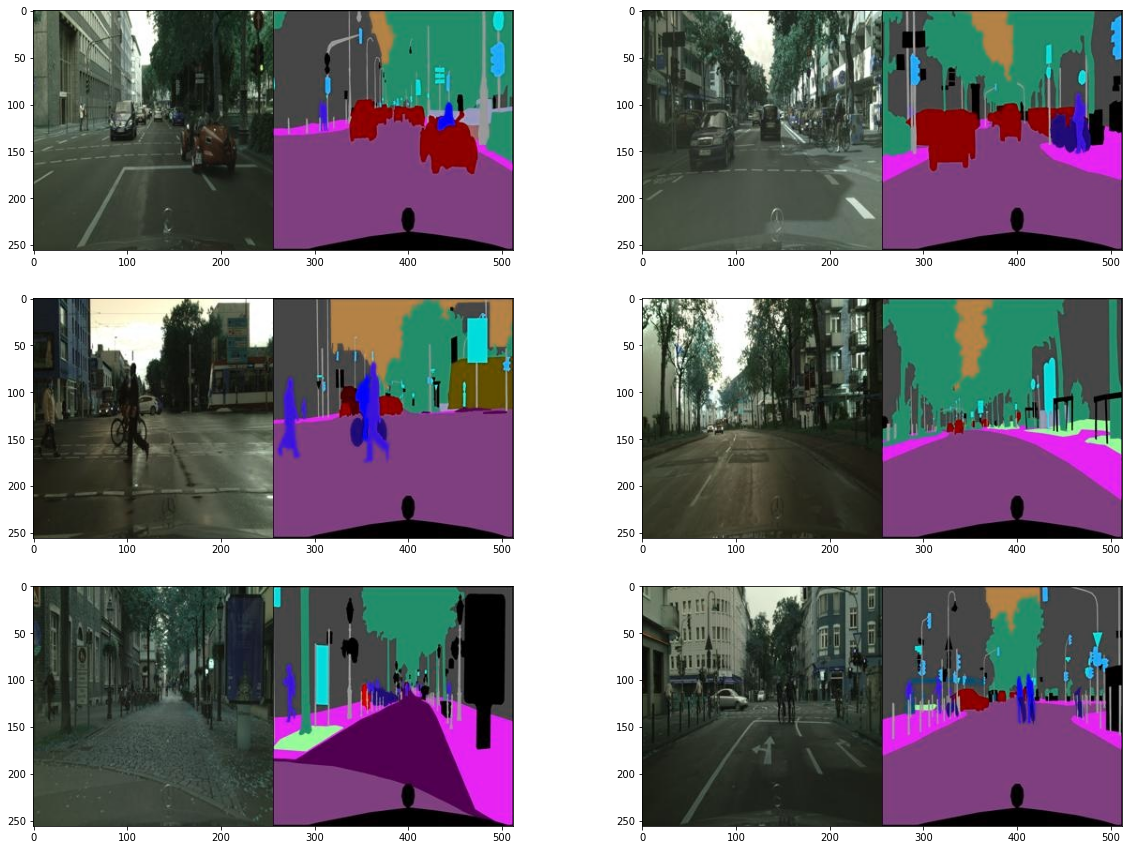

In [3]:
plt.figure(figsize=(20,15))
for i in range(1,7):
  f = data_path + os.listdir(data_path)[np.random.randint(1000)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)  # cv2.IMREAD_COLOR는 이미지파일을 컬러로 읽어드립니다.
  plt.subplot(3,2,i)
  plt.imshow(img)

이미지 하나를 열어 크기를 확인해보겠습니다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었고, 모델학습에 사용할 데이터를 (256, 256, 3)크기의 2개 이미지로 분할하여 사용하면 될 것 같습니다. 다음 코드로 이미지를 나눠보겠습니다.

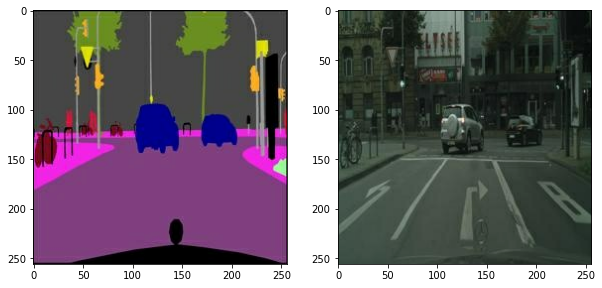

In [5]:
def normalize(x):
  x = tf.cast(x, tf.float32) # tf.cast()는 괄호안에 들어가는 배열의 dtype을 원하는 dtype으로 바꿔줍니다. 
  return (x/127.5) - 1 

def denormalize(x):
  x = (x+1)*127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path) # 이미지를 읽어옵니다.
  img = tf.image.decode_image(img, 3)

  w = tf.shape(img)[1] // 2  # 이미지의 가로길이설정
  colored = img[:, :w, :]
  colored = tf.cast(colored, tf.float32)
  segmentation = img[:, w:, :]
  segmentation = tf.cast(segmentation, tf.float32)
  return normalize(segmentation), normalize(colored)

f = data_path + os.listdir(data_path)[1]
segmentation, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

위와 같이 두개 이미지로 나뉘었습니다.

첫번째 이미지인 segmentation을 다음단계에서 구성할 Pix2Pix모델에 입력하여 두번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 프로젝트의 목표입니다.
# Step3. Augmentation
학습에 사용할 수 있는 데이터의 수는 1000개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation방법을 적용해 보겠습니다.

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(segmentation, colored):
  stacked = tf.concat([segmentation, colored], axis=-1) # 두이미지가 채널축으로 연결됩니다.

  _pad = tf.constant([[30,30], [30,30], [0,0]]) # tf.constant() 괄호안의 수나 배열을 텐서로만들어줌
  if tf.random.uniform(()) < .5:  # tf.random.uniform(()는 원하는 형태의 랜덤한 배열을 만듭니다.
    padded = tf.pad(stacked, _pad, "REFLECT")
  else:
    padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)  # tf.pad()은 지정한 패딩에따라 텐서를 채웁니다.

  out = image.random_crop(padded, size=[256, 256, 6])
  out = image.random_flip_left_right(out)
  out = image.random_flip_up_down(out)

  if tf.random.uniform(()) < .5:
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree)

  return out[...,:3], out[...,3:]

위 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다.
어떤 과정을 거치는지 순서대로 나열해보겠습니다.
1. 두 이미지가 채널 축으로 연결됩니다. 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
2. 50%확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다.
3. 방금의 결과에서 (256,256,6)크기를 가진 이미지를 임의로 잘라냅니다.
4. 50%확률로 가로로 뒤집습니다.
5. 50%확률로 세로로 뒤집습니다.
6. 50%확률로 회전시킵니다.

위와 같이 구성한 함수를 데이터에 적용해 시각화해보겠습니다.

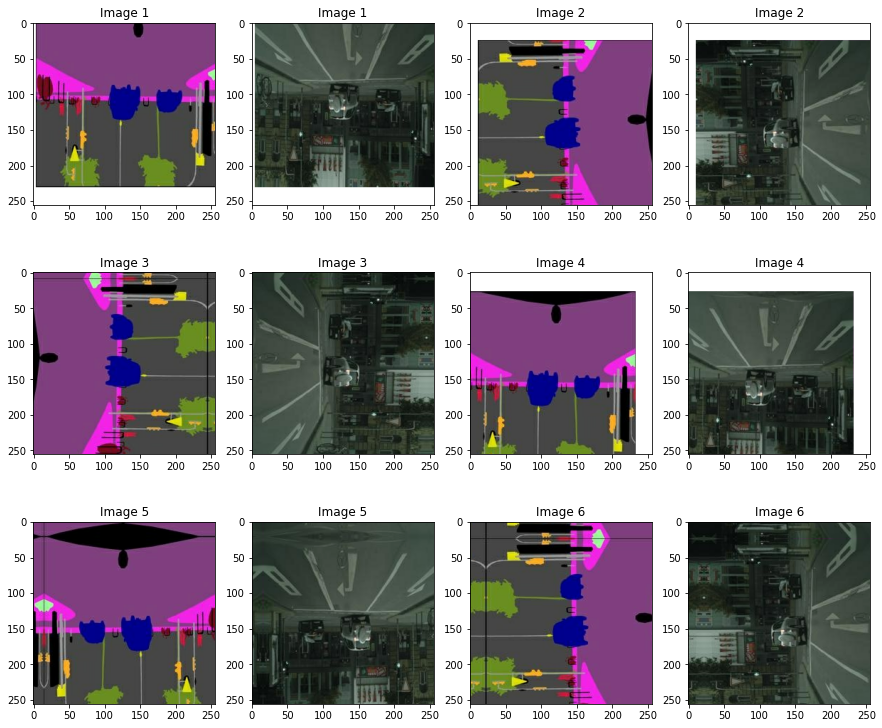

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
  augmented_segmentation, augmented_colored = apply_augmentation(segmentation, colored)
  plt.subplot(3,4,i)
  plt.imshow(denormalize(augmented_segmentation)); plt.title(f"Image {img_n}")
  plt.subplot(3,4,i+1)
  plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
  img_n += 1 

마지막으로 위 과정들을 학습 데이터에 적용하여, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해보겠습니다.

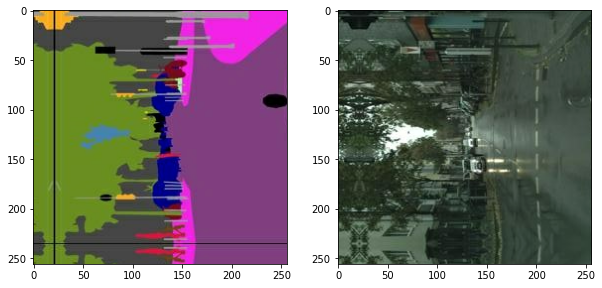

In [8]:
from tensorflow import data

def get_train(img_path):
    segmentation, colored = load_img(img_path)
    segmentation, colored = apply_augmentation(segmentation, colored)
    return segmentation, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmentation, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmentation[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Step4. Generator구성하기(U-Net) 
Pix2Pix의 Generator 구조는 Encoder-Decoder와 U-Net 두가지가있습니다. 하지만 단순한 Encoder-Decoder구조에 비해 Encoder와 Decoder사이를 skip connection으로 연결한 U-Net구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다. 

더 좋은 결과를 기대하기위해 U-Net구조로 Generator를 구성해 보겠습니다.

In [9]:
# 인코더 및 디코더에 사용되는 기본적인 블록입니다.
class EncodeBlock(layers.Layer):
  def __init__(self, n_filters, use_bn=True):
    super(EncodeBlock, self).__init__()
    self.use_bn = use_bn
    self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2)

  def call(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.batchnorm(x)
    return self.lrelu(x)

class DecodeBlock(layers.Layer):
  def __init__(self, f, dropout=True):
    super(DecodeBlock, self).__init__()
    self.dropout = dropout
    self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.relu = layers.ReLU()

  def call(self, x):
    x = self.Transconv(x)
    x = self.batchnorm(x)
    if self.dropout:
      x = layers.Dropout(.5)(x)
    return self.relu(x)

정의한 블록들을 이용해 한번에 U-Net Generator를 정의해 보겠습니다. 아래 모델의 __init__()메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 순전파 하도록합니다.

In [10]:
class UNetGenerator(Model):
  def __init__(self):
    super(UNetGenerator, self).__init__()
    encode_filters = [64,128,256,512,512,512,512,512]
    decode_filters = [512,512,512,512,256,128,64]

    self.encode_blocks = []
    for i, f in enumerate(encode_filters):
      if i == 0:
        self.encode_blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.encode_blocks.append(EncodeBlock(f))
    
    self.decode_blocks = []
    for i, f in enumerate(decode_filters):
      if i < 3:
        self.decode_blocks.append(DecodeBlock(f))
      else:
        self.decode_blocks.append(DecodeBlock(f, dropout=False))
    
    self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

  def call(self, x):
    features = []
    for block in self.encode_blocks:
      x = block(x)
      features.append(x)

    features = features[:-1] # 인코더의 마지막 출력은 디코더에 직접 입력되므로 제외합니다.

    for block, feat in zip(self.decode_blocks, features[::-1]): # features[::-1] : features에는 인코더블록들의 출력들이 순서대로쌓여있기때문에, 디코더에서는 역순으로 연결합니다.
      x = block(x)
      x = layers.Concatenate()([x, feat])

    x = self.last_conv(x)
    return x

  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

먼저, __init__()에서 정의된 encode_blocks 및 decode_blocks가 call()내부에서 차례대로 사용되어 Encoder 및 Decoder내부 연산을 수행합니다.

이때, Encoder와 Decoder 사이의 skip connection을 위해 features라는 리스트를 만들고 Encoder내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.

이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder블록들을 통과하는데, features리스트에 있는 각각의 출력들이 Decoder블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

In [11]:
# 완성된 U-Net구조 Generator내부의 각 출력이 적절한지 확인해봅니다.
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

# Step5. Discriminator 구성하기
Generator만으로 좋은결과를 도출하기에는 부족하기때문에 좀 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.

이번 단계에서 Discriminator를 만들어 Pix2Pix구조를 완성시켜봅시다.

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x


__init__()에서 필요한만큼 많은 설정을 가능하게끔 했습니다. 필터의수(n_filters),필터가 순회하는 간격(stride), 출력feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어 봅시다.

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

각 블록의 출력 크기가 알맞게 되었는지 확인해봅시다.

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

# Step6. 모델 학습
먼저 학습에 필요한 손실함수부터 정의하겠습니다. 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈습니다.

In [15]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

옵티마이저도 설정해줍니다.

In [16]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치크기만큼 데이터를 입력했을때 가중치를 1회 업데이트하는 과정은 다음과 같습니다.

In [17]:
@tf.function
def train_step(segmentation, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(segmentation, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segmentation, fake_colored, training=True)
        real_disc = discriminator(segmentation, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


위에서 정의한 함수를 이용해서 학습을 진행합니다.

In [18]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segmentation, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmentation, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 250 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[250]                     
Generator_loss:0.8294                     
L1_loss:0.2342                     
Discriminator_loss:0.7471

EPOCH[2] - STEP[250]                     
Generator_loss:0.7193                     
L1_loss:0.1667                     
Discriminator_loss:1.0090

EPOCH[3] - STEP[250]                     
Generator_loss:1.1670                     
L1_loss:0.2011                     
Discriminator_loss:1.1368

EPOCH[4] - STEP[250]                     
Generator_loss:2.0990                     
L1_loss:0.2098                     
Discriminator_loss:0.7013

EPOCH[5] - STEP[250]                     
Generator_loss:1.7960                     
L1_loss:0.1639                     
Discriminator_loss:0.8408

EPOCH[6] - STEP[250]                     
Generator_loss:1.9534                     
L1_loss:0.2057                     
Discriminator_loss:0.3545

EPOCH[7] - STEP[250]                     
Generator_loss:2.4351                     
L1_loss:0.1727             

# Step7. 테스트

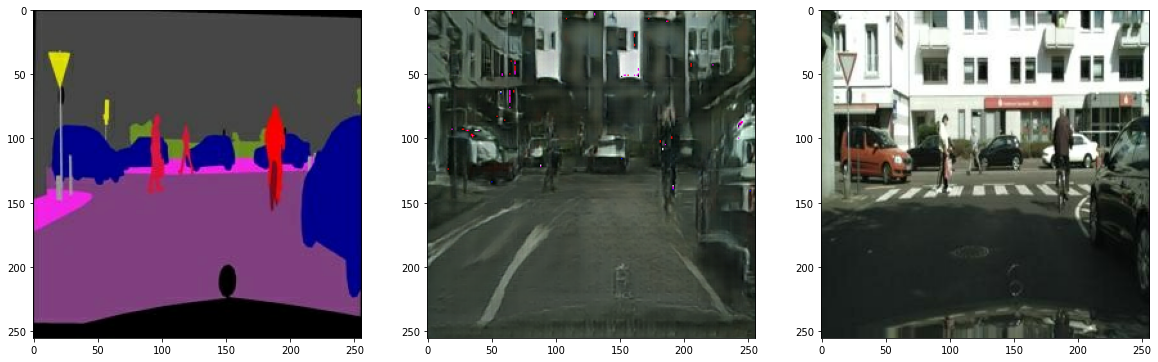

In [20]:
test_path = '/content/drive/MyDrive/Exploration_Data/ex16/cityscapes/val/'

f = test_path + os.listdir(test_path)[2]
segmentation, colored = load_img(f)

pred = generator(tf.expand_dims(segmentation, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 회고
- 이번실습에서는 이미지를 넣으면 이미지를 출력하는 Pix2Pix을 이용해봤다. 그리고 품질 개선을 위해 U-Net구조의 Generator를 사용했다.
- Augmentation을 사용해보았고, 어떤 식으로 이미지의 변환이 이루어졌는지 시각화를 해보았다. 하지만 단순한 뒤집기나 회전이 실제로 성능향상에 도움이 되는지가 이해가 되질 않는다. 어짜피 같은 이미지인데...
- 인코더와 디코더를 클래스를 이용해서 블록으로 정의한뒤 생성자와 판별자를 구성해봤는데, 많이 낯설었지만 매우 효율적인 구조라고 느꼈다.
- 최종적으로 300에포크를 돌렸지만, 사실 이전에 150에포크,100에포크,여러번의 50에포크를 많이 돌려봤다. 전부 아예 색깔 자체도 제대로 보이지 않는정도로 제대로 그려지지않았다. 그래서 처음엔 모델 구조가 잘못되었나?라고 생각이 들었지만, 일단 300에포크를 돌려봤다. 완벽하게 사물을 그려내지못했지만 그래도 어느정도 이해가능한 수준을 그려냈다. 주어진 segmentation에 해당하는 그림을 그려낸것으로 보인다. 따라서 모델 구조를 변화를 주면 더 성능이 올라가겠지만, 일단 절대적인 에포크 수자체가 더 중요한것으로 보인다. 노드를 진행할때도 500에포크로 학습된 가중치를 이용하니까 매우 잘그려냈었다. 